In [4]:
import pandas as pd
import numpy as np
import os
import opendatasets as od
import librosa as li
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import scipy.signal as signal

from IPython.display import Audio

### Import and Explore Dataset

Currently using the [British Birdsong Dataset](https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset?resource=download).


Download sound files from Kaggle.

(Get kaggle.json API token from [here](https://www.kaggle.com/settings) an place it in the notebooks folder).


In [5]:
# Download British Birdsong Dataset from Kaggle
dataset_url = ("https://www.kaggle.com/datasets/rtatman/british-birdsong-dataset?resource=download")
path_to_download = "../datasets"

od.download(dataset_url, data_dir=path_to_download)

Skipping, found downloaded files in "../datasets\british-birdsong-dataset" (use force=True to force download)


In [6]:
csv_path = path_to_download + '/british-birdsong-dataset/birdsong_metadata.csv'

metadata = pd.read_csv(csv_path)[['file_id', 'english_cname']]
metadata.rename(columns={'english_cname':'label'}, inplace=True)

In [7]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_butter_highpass(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [57]:
def remove_silence(signal, thresh=22, hop=2048, plot=False):
  splits = li.effects.split(y=signal, top_db=thresh, frame_length=(hop * 4), hop_length=hop)
  
  if plot:
    peak = np.max(signal)
    plt.subplots(figsize=(12,4))
    plt.plot(signal)
    plt.vlines(splits, ymin=-peak, ymax=peak, color='red')
    plt.show()
  
  stripped_audio = []
  
  for s in splits:
    split = signal[s[0]:s[1]]
    stripped_audio.extend(split)
  
  return np.asarray(stripped_audio)

In [59]:
# User defined constants
AUDIO_LENGHT = 3 # Seconds
TARGET_SAMPLE_RATE = 22050

sound_files_path = path_to_download + '/british-birdsong-dataset/songs/songs/'

# durations = []

for index, file_id, label in metadata.itertuples():
  # Read audio file from disk
  filename = sound_files_path + 'xc' + str(file_id) + '.flac'
  y, sr = li.load(filename, sr=None, mono=True)
  
  # Resample if needed
  if sr != TARGET_SAMPLE_RATE:
    y = li.resample(y=y, orig_sr=sr, target_sr=TARGET_SAMPLE_RATE)
    
  # Apply high-pass filter
  y = apply_butter_highpass(data=y, cutoff=500, fs=TARGET_SAMPLE_RATE, order=4)
  
  # Delete silent sections
  remove_silence(y, plot=False)
  
  # Split into segments of desired length
  
  # Append to new dataframe

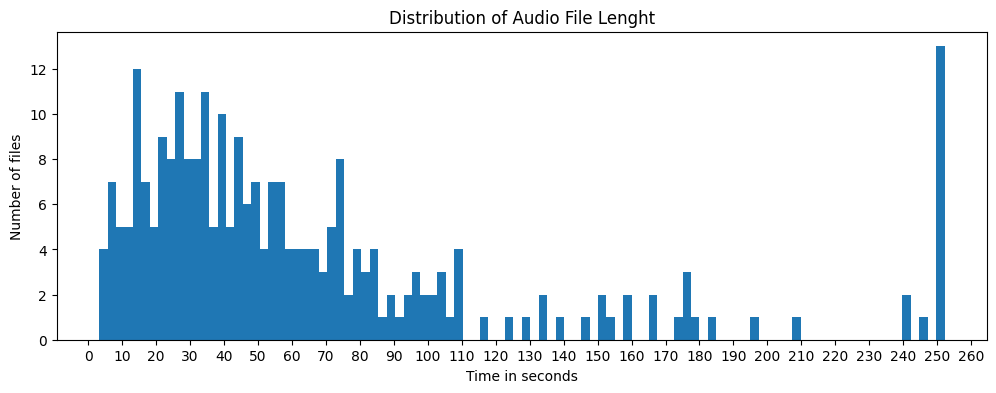

• Original file count: 264


In [16]:
# Plot histogram of original audio file durations
plt.subplots(figsize=(12, 4))
plt.title('Distribution of Audio File Lenght')
plt.xlabel('Time in seconds')
plt.ylabel('Number of files')
plt.xticks(range(0, 300, 10))
plt.hist(metadata['duration'], bins=100)
plt.show()

print(f'• Original file count: {len(metadata)}')
# print(f'• Total file count after splitting: {len(audio_data)}')

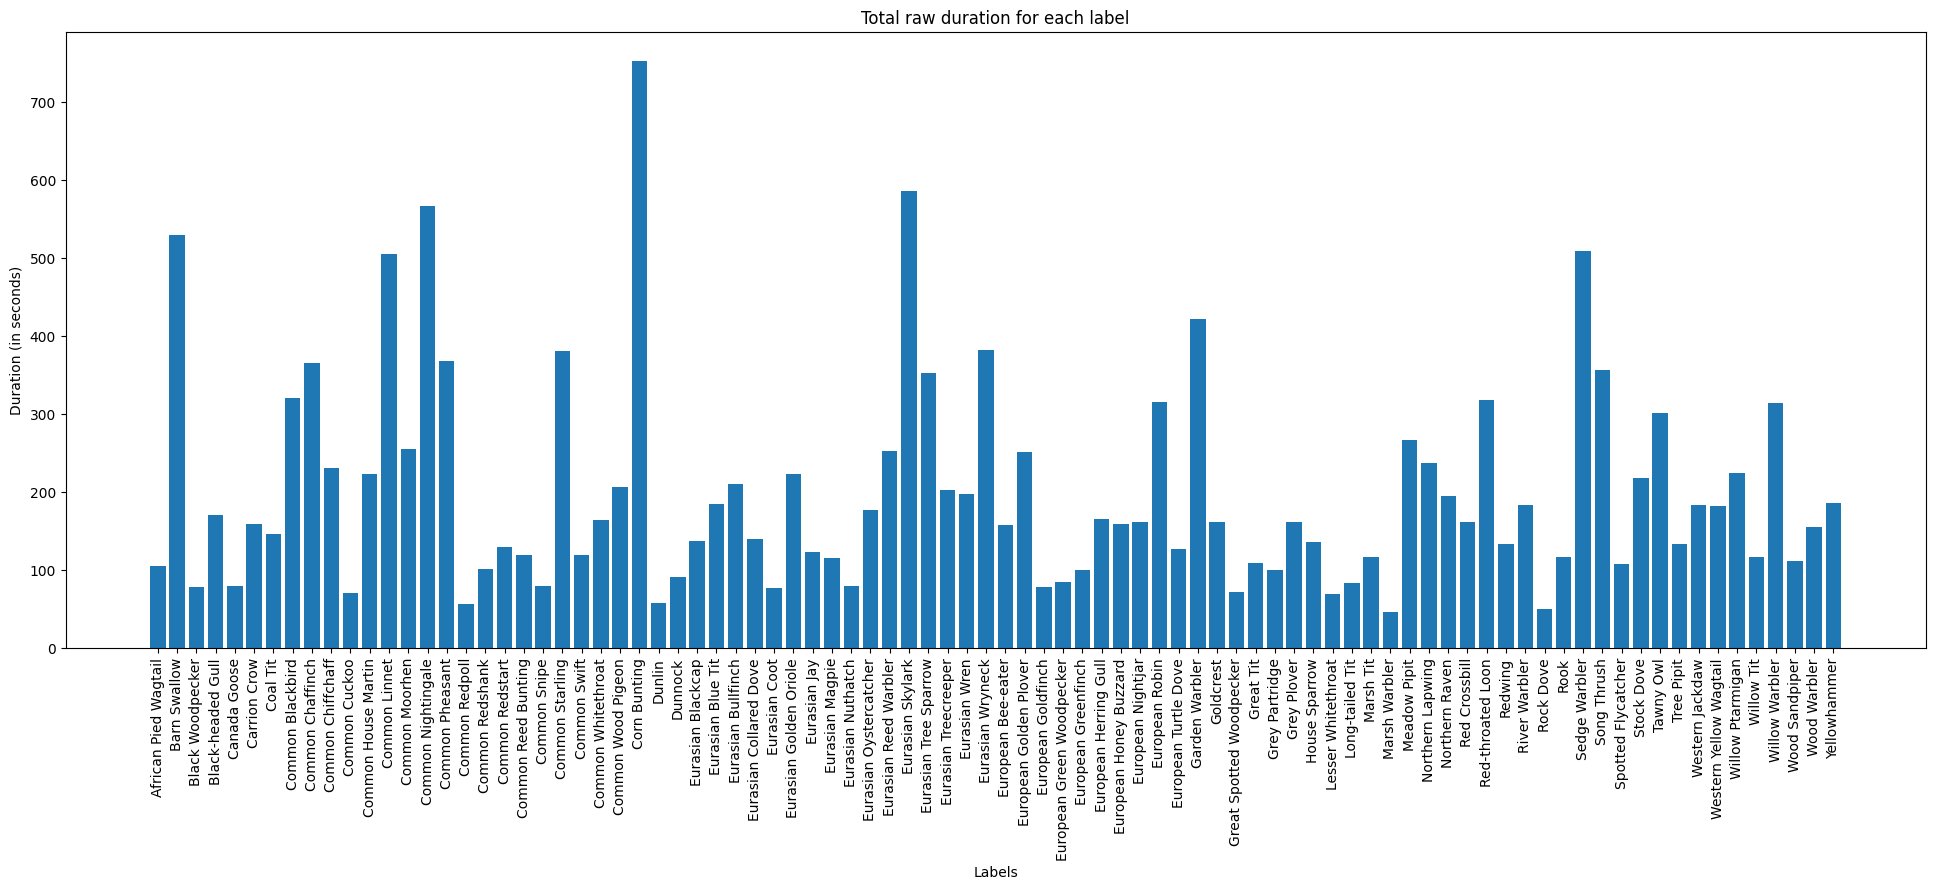

In [17]:
# Plot total duration for each label
duration_sum = metadata.groupby('label').sum()

fig, ax = plt.subplots(figsize=(24, 8))
ax.set_title('Total raw duration for each label')
ax.bar(x=duration_sum.index, height=duration_sum['duration'])
ax.set_ylabel('Duration (in seconds)')
ax.set_xlabel('Labels')
plt.xticks(rotation=90)
plt.show()